In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy import signal, stats
from hottbox.algorithms.decomposition.fusion import CMTF

import tensorly as tl

concentrations = pd.read_table("../Acar_data/concentrations.txt", sep="\s+")
mat = sio.loadmat("../Acar_data/EEM_NMR_LCMS.mat")

# Data description

# Mixture concentrations

In [2]:
print(concentrations.shape)
print((concentrations != 0).sum(axis=1).describe())

(28, 5)
count    28.000000
mean      3.321429
std       1.278123
min       1.000000
25%       3.000000
50%       4.000000
75%       4.000000
max       5.000000
dtype: float64


## Fluorescence Spectroscopy (Excitation Emission Matrix - EEM)

- 28 mixtures
- emission wavelength (mode 2)
- excitation wavelength (mode 3)

In [3]:
eem = mat["X"][0][0]["data"]

print(eem.shape)

(28, 251, 21)


## NMR spectra
- 28 mixtures
- chemical shifts (mode 2)
- gradient levels (mode 3)

In [4]:
nmr = mat["Y"][0][0]["data"]
print(nmr.shape)

(28, 13324, 8)


## LC-MS

Matrix n_mixtures x n_features

In [5]:
lcms = mat["Z"][0][0]["data"]

print(lcms.shape)

(28, 168)


# Tensor decomposition

In [102]:
ranks = range(1, 6)
errors = []
for rank in ranks:
    fac = tl.decomposition.parafac(nmr, rank=rank)
    err = tl.norm(tl.cp_to_tensor(fac) - nmr)
    errors.append(err)
errors = np.array(errors)

In [7]:
tl.cp_normalize(fac).shape

(28, 13324, 8)

In [ ]:
fac.shape

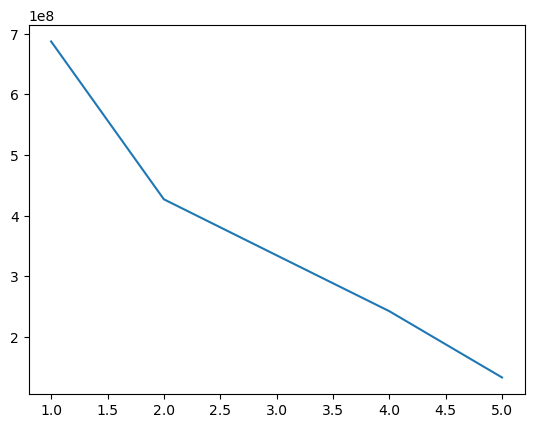

In [33]:
plt.plot(ranks, errors)

In [80]:
rank = 5
fac = tl.decomposition.non_negative_parafac(nmr, rank=rank)

In [82]:
fac = tl.cp_normalize(fac)

(28, 5)


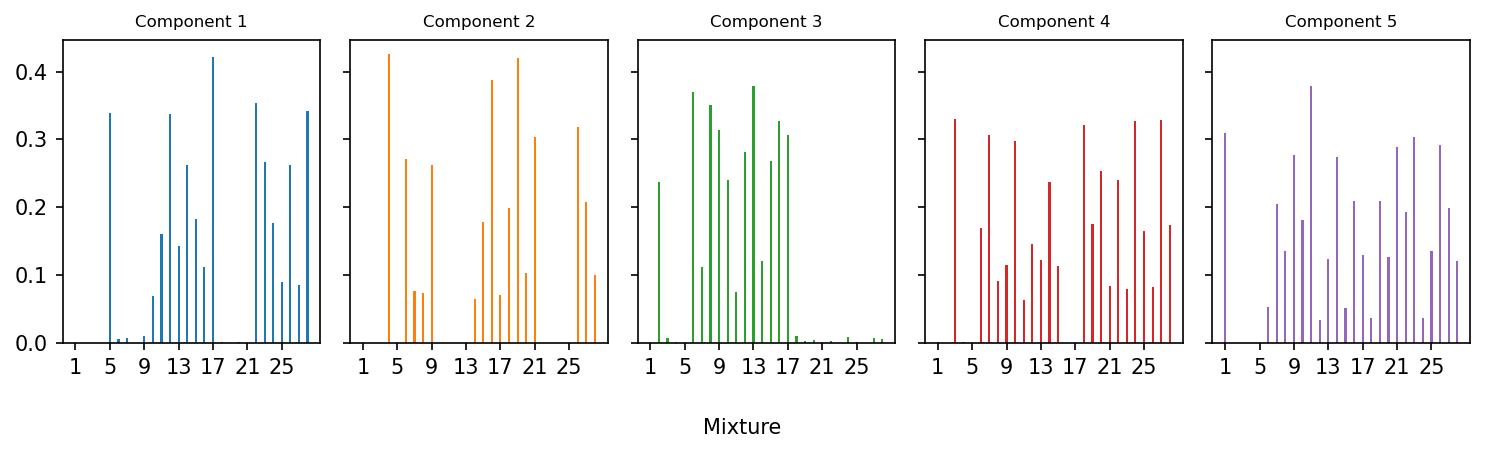

In [106]:
f, ax = plt.subplots(1, rank, figsize=(10, 3), sharex=True, sharey=True, dpi=150)

components = [1, 2, 3]
width = 0.25

lig_facs = fac[1][0]
print(lig_facs.shape)
x_lig = np.arange(28)

for i in range(rank):
    ax[i].bar(x_lig, lig_facs[:, i], width, label="Component 1", color=f"C{i}")
    ax[i].set_title(f"Component {i + 1}", fontsize=8)
ax[0].set_xticks(x_lig[::4], (x_lig + 1)[::4])
f.supxlabel("Mixture", fontsize=10)
f.tight_layout()
f.savefig("figures/parafac_nmr_spectra_cp_factors_per_mixture.pdf", dpi=300)
plt.show()

In [84]:
from scipy.stats import spearmanr

col_names = concentrations.columns
for cp_idx in range(5):
    print(f"Component {cp_idx + 1}")
    for col_idx in range(5):
        cor_res = spearmanr(lig_facs[:, cp_idx], concentrations.iloc[:, col_idx])
        if np.abs(cor_res.statistic) > 0.5:
            print(f"{col_names[col_idx]}\t", cor_res)

Component 1
Propanol	 SignificanceResult(statistic=0.9552092650361735, pvalue=2.8817844723874596e-15)
Component 2
Malto	 SignificanceResult(statistic=0.952483574109862, pvalue=6.115796232408e-15)
Component 3
Trp-Gly	 SignificanceResult(statistic=0.8935844618051503, pvalue=1.552649102529658e-10)
Component 4
Phe	 SignificanceResult(statistic=0.9579524854000545, pvalue=1.2870795266589864e-15)
Component 5
Val-Tyr-Val	 SignificanceResult(statistic=0.9813532428193826, pvalue=3.768841797526262e-20)


In [104]:
mask = np.isnan(eem)
eem[mask] = 0
fac_eem = tl.decomposition.non_negative_parafac(eem, rank=rank, init="svd")
fac_eem = tl.cp_normalize(fac_eem)

In [105]:
from scipy.stats import spearmanr

lig_facs = fac_eem[1][0]

col_names = concentrations.columns
for cp_idx in range(5):
    print(f"Component {cp_idx + 1}")
    for col_idx in range(5):
        cor_res = spearmanr(lig_facs[:, cp_idx], concentrations.iloc[:, col_idx])
        if np.abs(cor_res.statistic) > 0.5:
            print(f"{col_names[col_idx]}\t", cor_res)

Component 1
Val-Tyr-Val	 SignificanceResult(statistic=0.9813532428193826, pvalue=3.768841797526262e-20)
Component 2
Phe	 SignificanceResult(statistic=0.9759000729485333, pvalue=1.0262424147542531e-18)
Component 3
Trp-Gly	 SignificanceResult(statistic=0.9151166175112985, pvalue=9.312591943635472e-12)
Component 4
Trp-Gly	 SignificanceResult(statistic=0.9151166175112985, pvalue=9.312591943635472e-12)
Component 5
Trp-Gly	 SignificanceResult(statistic=0.8568003624738137, pvalue=5.93105905060349e-09)


# CMTF

In [22]:
from cmtf import CMTF
from utils import replace_nan

tensor_1 = replace_nan(nmr, strategy="zero")
tensor_2 = replace_nan(eem, strategy="zero")
cmtf = CMTF(max_iter=1000)
out = cmtf.fit([tensor_1, tensor_2], [lcms], rank=5)

2025-04-23 10:18:22,010 - Starting CMTF fit for rank = 5, lmbda = 1 with 1 tensors and 1 matrices
2025-04-23 10:18:25,925 - [Iter 100] delta U1 = 54844.87900607
2025-04-23 10:18:28,922 - [Iter 200] delta U1 = 21455.71870827
2025-04-23 10:18:31,594 - [Iter 300] delta U1 = 7741.41925949
2025-04-23 10:18:36,400 - [Iter 400] delta U1 = 4291.10106707
2025-04-23 10:18:39,421 - [Iter 500] delta U1 = 2899.49484619
2025-04-23 10:18:43,392 - [Iter 600] delta U1 = 2255.28505465
2025-04-23 10:18:46,030 - [Iter 700] delta U1 = 1925.74945495
2025-04-23 10:18:49,205 - [Iter 800] delta U1 = 1751.42173070
2025-04-23 10:18:52,628 - [Iter 900] delta U1 = 1647.85165693
2025-04-23 10:18:55,645 - [Iter 1000] delta U1 = 1571.86974703


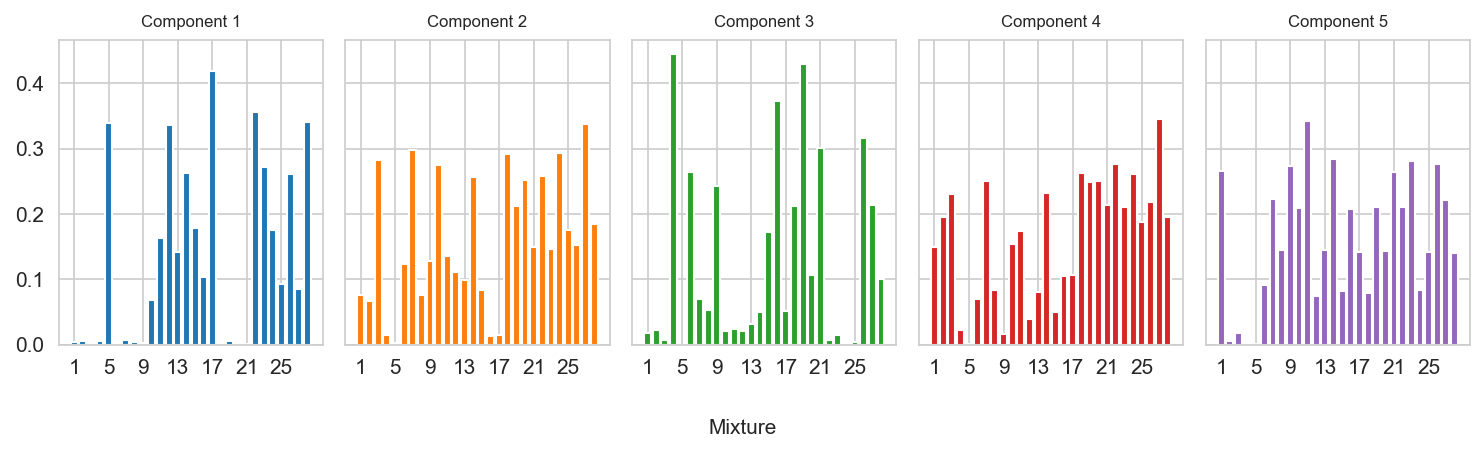

In [48]:
rank = 5
f, ax = plt.subplots(1, rank, figsize=(10, 3), sharex=True, sharey=True, dpi=150)

u1 = out[0]
u1 = tl.cp_normalize((None, [u1])).factors[0]
x_ticks = np.arange(28)

for i in range(rank):
    ax[i].bar(x_ticks, np.abs(u1[:, i]), color=f"C{i}")
    ax[i].set_title(f"Component {i + 1}", fontsize=8)
ax[0].set_xticks(x_ticks[::4], (x_ticks + 1)[::4])
f.supxlabel("Mixture", fontsize=10)
f.tight_layout()
plt.show()